In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,866 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [0]:
import re
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import pytesseract as tes
import cv2
from google.colab.patches import cv2_imshow
import scipy.misc
from scipy import ndimage
from scipy.ndimage import interpolation as inter

In [0]:
def get_adhaar_num(txt):
  dit={}
  val=re.findall(r'\d{4} \d{4} \d{4}',txt)
  fadh=""
  mx=0
  for v in val:
    if v not in dit:
      dit[v]=1
    else:
      dit[v]+=1
    if mx<dit[v]:
      fadh=v
  fadh=fadh.split(' ')
  fadh="".join(fadh)
  return fadh

In [0]:
def mask_number(fadh,boxes,img):
  txt_bx=""
  for b in boxes:
    txt_bx+=b[0]
  dit={}
  iter=re.finditer(fadh,txt_bx)
  r=l=t=d=0
  for i in iter:
    b=boxes[i.start(0)]
    b=b.split()
    l=int(b[1])
    d=hi-int(b[2])
    b=boxes[i.start(0)+11]
    b=b.split()
    r=int(b[3])
    t=hi-int(b[4])
    pts=np.array([[l-5,t-5],[l-5,d+5],[r+5,d+5],[r+5,t-5]],dtype=np.int32)
    img=cv2.fillPoly(img,[pts],color=(0,0,0))
  return img

In [0]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated

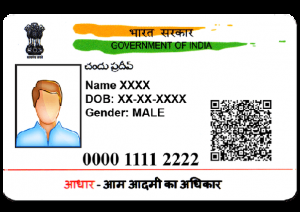

In [7]:
im = Image.open('Aadhaar-card.png') 
im= cv2.cvtColor(np.asarray(im), cv2.COLOR_RGB2BGR)
img=im
im= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im=np.array(im)
hi,wi=im.shape
im=correct_skew(im)[1]
cv2_imshow(img)

In [8]:
txt = tes.image_to_string(im)
boxes=tes.image_to_boxes(im)
boxes=boxes.split('\n')
'''for b in boxes:
  b=b.split()
  #print(b)
  x,y,w,h=int(b[1]),hi-int(b[2]),int(b[3]),hi-int(b[4])
  cv2.rectangle(im,(x,y),(w,h),(0,0,255))'''

'for b in boxes:\n  b=b.split()\n  #print(b)\n  x,y,w,h=int(b[1]),hi-int(b[2]),int(b[3]),hi-int(b[4])\n  cv2.rectangle(im,(x,y),(w,h),(0,0,255))'

In [0]:
adhaar_num=get_adhaar_num(txt)
im=mask_number(adhaar_num,boxes,img)

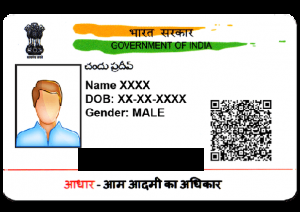

In [10]:
cv2_imshow(im)